# Libraries

In [1]:
# install.packages('')

In [1]:
library(caTools)
library(ggplot2)
library(repr)
options(repr.plot.width=8,repr.plot.height=4)
library(arules)
library(arulesViz)

Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: grid


# Read data

In [2]:
root_dir="~/Documents/Education/20170623 Udemy - Machine Learning A-Z: Hands-On Python and R in Data Science/"
work_dir="Course data/Part 5 - Association Rule Learning/Section 29 - Eclat"
setwd(paste(root_dir,work_dir,sep=''))
df=read.csv('Market_Basket_Optimisation.csv',header=FALSE)
str(df)

'data.frame':	7501 obs. of  20 variables:
 $ V1 : Factor w/ 115 levels "almonds","antioxydant juice",..: 96 15 27 108 72 65 112 98 49 43 ...
 $ V2 : Factor w/ 118 levels "","almonds","antioxydant juice",..: 2 69 1 5 71 1 43 63 99 1 ...
 $ V3 : Factor w/ 116 levels "","almonds","antioxydant juice",..: 5 36 1 1 37 1 1 93 53 1 ...
 $ V4 : Factor w/ 115 levels "","almonds","antioxydant juice",..: 107 1 1 1 112 1 1 1 1 1 ...
 $ V5 : Factor w/ 111 levels "","almonds","antioxydant juice",..: 50 1 1 1 51 1 1 1 1 1 ...
 $ V6 : Factor w/ 107 levels "","almonds","antioxydant juice",..: 103 1 1 1 1 1 1 1 1 1 ...
 $ V7 : Factor w/ 103 levels "","almonds","antioxydant juice",..: 101 1 1 1 1 1 1 1 1 1 ...
 $ V8 : Factor w/ 99 levels ""," asparagus",..: 34 1 1 1 1 1 1 1 1 1 ...
 $ V9 : Factor w/ 89 levels "","almonds","antioxydant juice",..: 36 1 1 1 1 1 1 1 1 1 ...
 $ V10: Factor w/ 81 levels "","asparagus",..: 74 1 1 1 1 1 1 1 1 1 ...
 $ V11: Factor w/ 67 levels "","asparagus",..: 40 1 1 1 1 1 1 1 1

In [5]:
products=sort(unique(unlist(df)))
writeLines(noquote(paste(length(products)-1,'different products:')))
print(products)

120 different products:
  [1] almonds              antioxydant juice    asparagus           
  [4] avocado              babies food          bacon               
  [7] barbecue sauce       black tea            blueberries         
 [10] body spray           bramble              brownies            
 [13] bug spray            burger sauce         burgers             
 [16] butter               cake                 candy bars          
 [19] carrots              cauliflower          cereals             
 [22] champagne            chicken              chili               
 [25] chocolate            chocolate bread      chutney             
 [28] cider                clothes accessories  cookies             
 [31] cooking oil          corn                 cottage cheese      
 [34] cream                dessert wine         eggplant            
 [37] eggs                 energy bar           energy drink        
 [40] escalope             extra dark chocolate flax seed           
 [43] fren

# Replace malformed labels

In [6]:
substitutions=list(' asparagus'='asparagus')
for(target in names(substitutions)){
    df[df==target]=substitutions[[target]]
}
products=sort(unique(unlist(df)))
writeLines(noquote(paste(length(products)-1,'different products:')))
print(products)

119 different products:
  [1] almonds              antioxydant juice    asparagus           
  [4] avocado              babies food          bacon               
  [7] barbecue sauce       black tea            blueberries         
 [10] body spray           bramble              brownies            
 [13] bug spray            burger sauce         burgers             
 [16] butter               cake                 candy bars          
 [19] carrots              cauliflower          cereals             
 [22] champagne            chicken              chili               
 [25] chocolate            chocolate bread      chutney             
 [28] cider                clothes accessories  cookies             
 [31] cooking oil          corn                 cottage cheese      
 [34] cream                dessert wine         eggplant            
 [37] eggs                 energy bar           energy drink        
 [40] escalope             extra dark chocolate flax seed           
 [43] fren

# Remove duplicates within rows

In [7]:
dups=apply(df,1,function(row) anyDuplicated(row,incomparables=c('')))
df[dups!=0,]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
4395,burgers,ham,eggs,whole wheat rice,ham,french fries,cookies,green tea,,,,,,,,,,,,
4495,ham,eggs,honey,gums,light cream,ham,,,,,,,,,,,,,,
4527,ham,milk,chicken,whole wheat rice,ham,eggplant,,,,,,,,,,,,,,
6904,ground beef,spaghetti,mineral water,chocolate,salmon,chicken,chocolate,frozen smoothie,,,,,,,,,,,,
7110,ham,shrimp,milk,flax seed,salmon,corn,ham,eggplant,,,,,,,,,,,,


In [8]:
for(rowNum in rownames(df[dups!=0,])){
    df[rowNum,duplicated(c(t(df[rowNum,])),incomparables=c(''))]=''
}
df[dups!=0,]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
4395,burgers,ham,eggs,whole wheat rice,,french fries,cookies,green tea,,,,,,,,,,,,
4495,ham,eggs,honey,gums,light cream,,,,,,,,,,,,,,,
4527,ham,milk,chicken,whole wheat rice,,eggplant,,,,,,,,,,,,,,
6904,ground beef,spaghetti,mineral water,chocolate,salmon,chicken,,frozen smoothie,,,,,,,,,,,,
7110,ham,shrimp,milk,flax seed,salmon,corn,,eggplant,,,,,,,,,,,,


# Doing it all at once

In [9]:
df=read.transactions('Market_Basket_Optimisation.csv',sep=',',rm.duplicates=TRUE)
str(df)

distribution of transactions with duplicates:
1 
5 
Formal class 'transactions' [package "arules"] with 3 slots
  ..@ data       :Formal class 'ngCMatrix' [package "Matrix"] with 5 slots
  .. .. ..@ i       : int [1:29358] 0 1 3 32 38 47 52 53 59 64 ...
  .. .. ..@ p       : int [1:7502] 0 20 23 24 26 31 32 34 37 40 ...
  .. .. ..@ Dim     : int [1:2] 119 7501
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : NULL
  .. .. .. ..$ : NULL
  .. .. ..@ factors : list()
  ..@ itemInfo   :'data.frame':	119 obs. of  1 variable:
  .. ..$ labels: chr [1:119] "almonds" "antioxydant juice" "asparagus" "avocado" ...
  ..@ itemsetInfo:'data.frame':	0 obs. of  0 variables


In [10]:
summary(df)

transactions as itemMatrix in sparse format with
 7501 rows (elements/itemsets/transactions) and
 119 columns (items) and a density of 0.03288973 

most frequent items:
mineral water          eggs     spaghetti  french fries     chocolate 
         1788          1348          1306          1282          1229 
      (Other) 
        22405 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1754 1358 1044  816  667  493  391  324  259  139  102   67   40   22   17    4 
  18   19   20 
   1    2    1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   3.914   5.000  20.000 

includes extended item information - examples:
             labels
1           almonds
2 antioxydant juice
3         asparagus

In [11]:
duplicated(itemInfo(df))

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

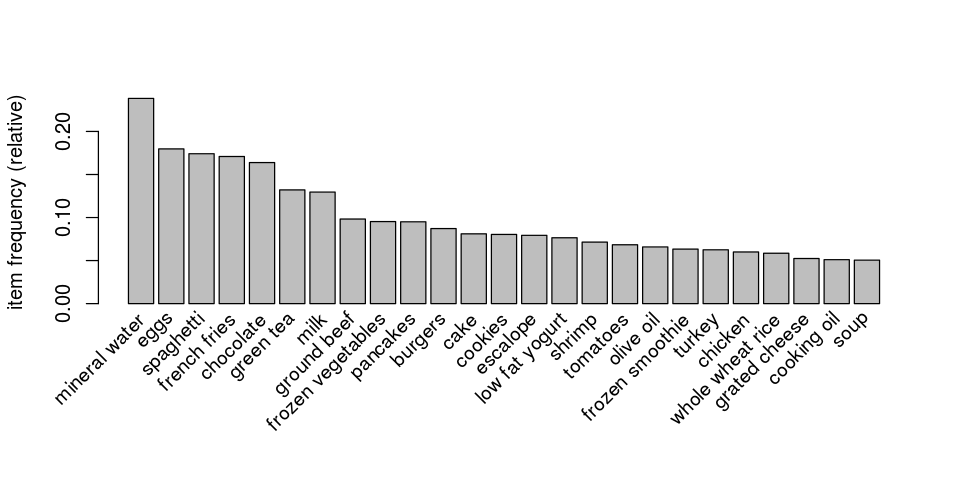

In [12]:
itemFrequencyPlot(df,topN=25)

# Finding the rules

In [13]:
min_buys_per_day=3
min_support=min_buys_per_day*7/length(df)
min_support

[1] 0.002799627

In [14]:
rules=eclat(data=df,parameter=list(support=0.003,minlen=2))

Eclat

parameter specification:
 tidLists support minlen maxlen            target   ext
    FALSE   0.003      2     10 frequent itemsets FALSE

algorithmic control:
 sparse sort verbose
      7   -2    TRUE

Absolute minimum support count: 22 

create itemset ... 
set transactions ...[119 item(s), 7501 transaction(s)] done [0.00s].
sorting and recoding items ... [115 item(s)] done [0.00s].
creating sparse bit matrix ... [115 row(s), 7501 column(s)] done [0.00s].
writing  ... [1328 set(s)] done [0.01s].
Creating S4 object  ... done [0.00s].


In [15]:
inspect(head(sort(rules,by='support'),10))

     items                             support   
[1]  {mineral water,spaghetti}         0.05972537
[2]  {chocolate,mineral water}         0.05265965
[3]  {eggs,mineral water}              0.05092654
[4]  {milk,mineral water}              0.04799360
[5]  {ground beef,mineral water}       0.04092788
[6]  {ground beef,spaghetti}           0.03919477
[7]  {chocolate,spaghetti}             0.03919477
[8]  {eggs,spaghetti}                  0.03652846
[9]  {eggs,french fries}               0.03639515
[10] {frozen vegetables,mineral water} 0.03572857


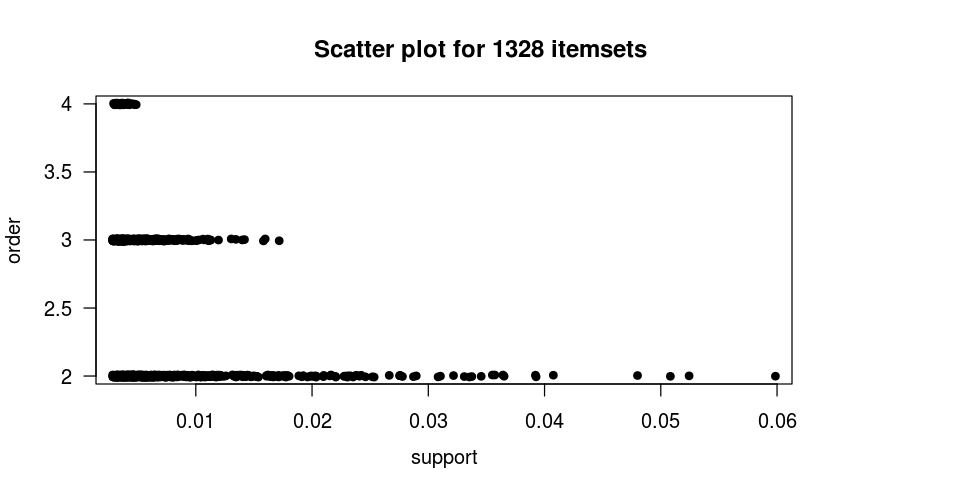

In [16]:
plot(rules)